# Chapter 14: Deep CV Using CNNs

In [1]:
# Libraries
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Seeds
np.random.seed(42)
tf.random.set_seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 1. Overview

### 1.1 Motivation

Importance of parameter sharing!
- _e.g._ : 100x100 img $\to$ 10,000 pixels $\to$ 1,000 neurons in the first layer $\to$ 10 million params!!

### 1.2 Convolution

Pixel intensity is in $[0, 255]$ - scale features to get floats in $[0, 1]$

In [2]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

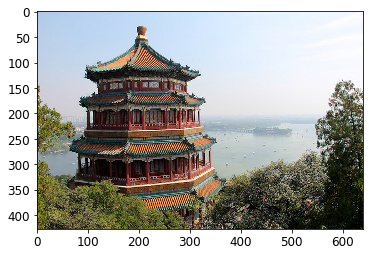

In [3]:
plt.imshow(china)

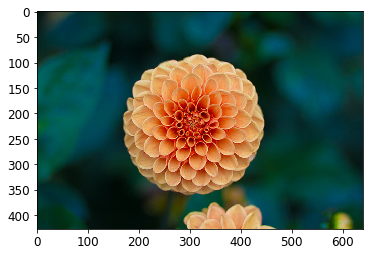

In [4]:
plt.imshow(flower)

Create two $7 \times 7$ filters:
- One with vertical white line
- Other with horizontal white line

In [7]:
# Create two filters
filters = np.zeros(shape = (7, 7, channels, 2), dtype = np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

outputs = tf.nn.conv2d(images, filters, strides = 1, padding = "SAME")

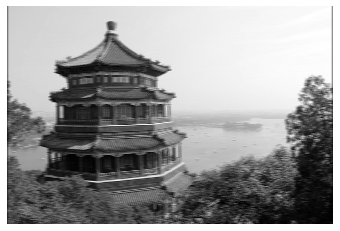

In [8]:
plt.imshow(outputs[0, :, :, 1], cmap = "gray") # plot 1st image's second feature map
plt.axis("off")
plt.show()

In [10]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

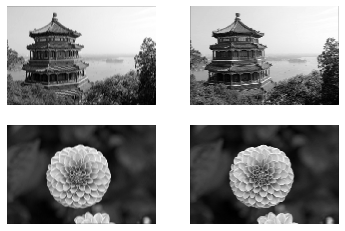

In [11]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])
        
plt.show()

In [14]:
def crop(images):
    return images[150:220, 130:250]

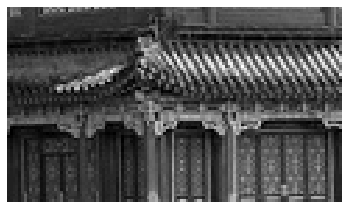

In [15]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

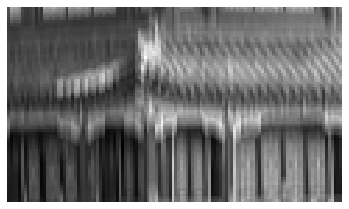

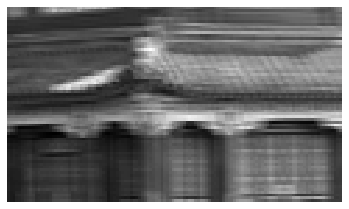

In [17]:
for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

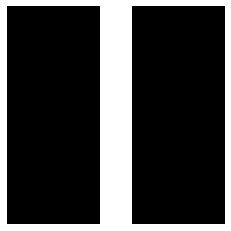

In [18]:
plot_image(filters[:, :, 0, 0])
plt.show()

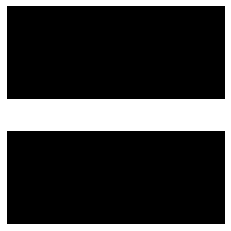

In [19]:
plot_image(filters[:, :, 0, 1])
plt.show()

### 1.3 Convolution layer review

`tf.nn.conv2d()` :
   - `images` : input mini-batch; 4D tensor
   - `filters` : set of filters to apply
   - `strides` : how to move the convolution
   - `padding` : one of `SAME` (use zero padding) or `VALID` (only uses what the image already provides)

In [20]:
# Example

conv = keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1,
                          padding = "same", activation = "relu")

### 1.4 VALID vs. SAME padding

In [22]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [23]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [24]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [25]:
kernel_size = 7
strides = 1

conv_valid = keras.layers.Conv2D(filters = 1, kernel_size = kernel_size, strides = strides, padding = "VALID")
conv_same = keras.layers.Conv2D(filters = 1, kernel_size = kernel_size, strides = strides, padding = "SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

In [26]:
# Call build() to create conv_same's weights
conv_same.build(tf.TensorShape(images.shape))

In [27]:
# Copy weights from conv_valid
conv_same.set_weights(conv_valid.get_weights())

In [28]:
same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

## 2. Pooling Layer

### 2.1 Max pooling

Simple & common: take max input in kernel

__Pros__ :
- Reduce computations
- Reduce memory usage & parameters
- Some level of invariance to _small_ translations, rotations, and scale

__Cons__ :
- Destructive: even with tiny 2x2 kernel, output is halved in each dimension (4x smaller)
- Some applications don't want _invariance_ (small shift $\implies$ no output change) but rather _equivariance_ (small shift $\implies$ small output change)

In [30]:
max_pool = keras.layers.MaxPool2D(pool_size = 2) # uses VALID/no padding by default

In [31]:
cropped_images = np.array([crop(image) for image in images], dtype = np.float32)
output = max_pool(cropped_images)

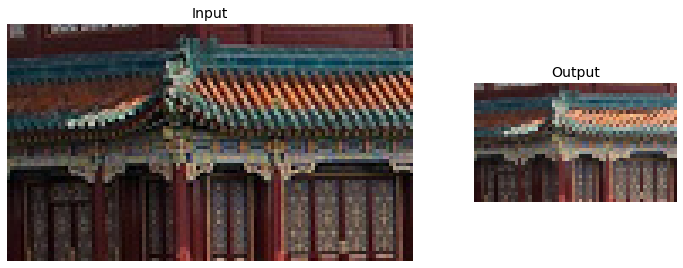

In [32]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### 2.2 Average pooling

Used to be popular, has since fallen out of favor
- Max pooling preserves only strongest features $\implies$ cleaner signal to subsequent layers
- Max pool also tends to perform better

In [33]:
avg_pool = keras.layers.AvgPool2D(pool_size = 2)

In [34]:
output = avg_pool(cropped_images)

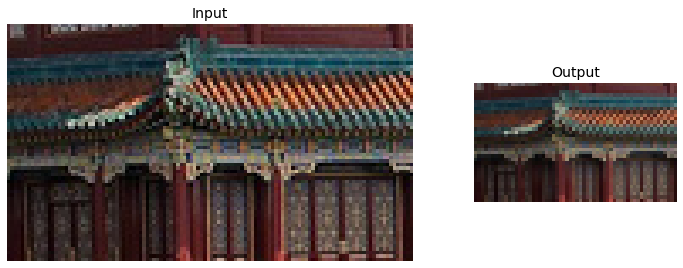

In [35]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### 2.3 Depth-wise pooling

Can also pool along the depth dimension rather than spatial dimensions (not as common)
- In theory, could allow CNN to learn to be invariant to various features
- _Examples_ : thickness, brightness, skewness, color, etc.

No depthwise max pool in keras, but one exists in `tf` low-level api $\to$ `tf.nn.max_pool()`

In [36]:
output = tf.nn.max_pool(images,
                       ksize = (1, 1, 1, 3),
                       strides = (1, 1, 1, 3),
                       padding = "VALID")

In [38]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [39]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

Can also employ `Lambda` layer

In [40]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(X,
                                                          ksize = (1, 1, 1, 3),
                                                         strides = (1, 1, 1, 3),
                                                         padding = "VALID"))

with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

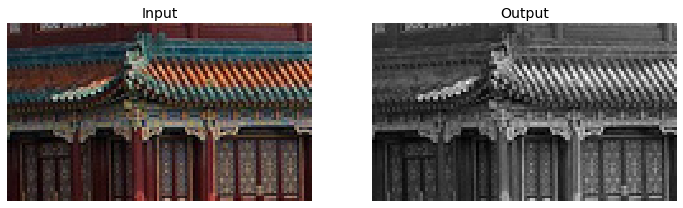

In [41]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

### 2.4 Global average pool

Computes mean of the entire feature map; single number per feature map and per instance
- Extremely destructive, but potentially useful as the output layer

In [42]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

Equivalent representation as a `Lambda` layer

In [43]:
output_global_avg_2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis = [1, 2]))
output_global_avg_2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

## 3. CNN Architectures

### 3.1 Fashion MNIST example

Most CNNs follow input $\to$ conv $\to$ pool $\to$ conv $\to \cdots \to$ pool $\to$ FC $\to \cdots$

__Performance notes__ :
- Common mistake to use kernels that are too large; instead of 5x5 kernel, stack two layers with 3x3 kernels
    - Fewer params, fewer computations, usually better performance
- Exception: first conv layer typically has large kernel, with small stride

In [44]:
# Load the data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [47]:
X_train.shape # 55k 28x28 grayscale images

(55000, 28, 28, 1)

In [48]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                       kernel_size = 3, activation = 'relu', padding = "SAME")

In [50]:
model = keras.models.Sequential([
    DefaultConv2D(filters = 64, kernel_size = 7, input_shape = [28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size = 2),
    DefaultConv2D(filters = 128),
    DefaultConv2D(filters = 128),
    keras.layers.MaxPooling2D(pool_size = 2),
    DefaultConv2D(filters = 256),
    DefaultConv2D(filters = 256),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units = 64, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units = 10, activation = "softmax")
])

In [ ]:
# Run the model -- need to use GPU
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_valid, y_valid))